In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import sys
import warnings
import gc

from matplotlib import pyplot as plt
from dotenv import load_dotenv
from sklearn.preprocessing import StandardScaler

sys.path.append("../")

load_dotenv()
sns.color_palette('colorblind')
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

try:
    pc_dpi = int(os.getenv('DPI'))
except TypeError:
    pc_dpi = 100
if pc_dpi is None:
    pc_dpi = 100


# Purpose :

- Understanding the datasets
- Merging datasets
- Encoding and preprocessing features
- Readying data for models

### Source :
- The preprocessing is derived from a kaggle kernel : https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

<hr>

# Loading and merging train/test :
- Train and test must be processed in the same way
- application_train.csv will be the data used to create, test and fine tune the model(s)
- application_test.csv (without `"TARGET"`) will be used as customer data

# Goal of this step : 
- Defining and preprocessing the different kind of variables : numerical, categorical non binary and categorical binary
- Encoding non-binary variables
- Scaling the numerical data
- Creating a general purpose function that can be applied for each new customer

In [2]:
application_train_csv = "../data/application_train.csv"

df_train = pd.read_csv(filepath_or_buffer=application_train_csv)


In [3]:
print(f"Number of columns : {df_train.columns.__len__()}\n")

print(f"Data types :\n{df_train.dtypes.value_counts()}")


Number of columns : 122

Data types :
float64    65
int64      41
object     16
dtype: int64


In [4]:
na_dict = {}

for key, value in df_train.isna().sum().items():
    if value != 0:
        na_dict[key] = value

display(na_dict)


{'AMT_ANNUITY': 12,
 'AMT_GOODS_PRICE': 278,
 'NAME_TYPE_SUITE': 1292,
 'OWN_CAR_AGE': 202929,
 'OCCUPATION_TYPE': 96391,
 'CNT_FAM_MEMBERS': 2,
 'EXT_SOURCE_1': 173378,
 'EXT_SOURCE_2': 660,
 'EXT_SOURCE_3': 60965,
 'APARTMENTS_AVG': 156061,
 'BASEMENTAREA_AVG': 179943,
 'YEARS_BEGINEXPLUATATION_AVG': 150007,
 'YEARS_BUILD_AVG': 204488,
 'COMMONAREA_AVG': 214865,
 'ELEVATORS_AVG': 163891,
 'ENTRANCES_AVG': 154828,
 'FLOORSMAX_AVG': 153020,
 'FLOORSMIN_AVG': 208642,
 'LANDAREA_AVG': 182590,
 'LIVINGAPARTMENTS_AVG': 210199,
 'LIVINGAREA_AVG': 154350,
 'NONLIVINGAPARTMENTS_AVG': 213514,
 'NONLIVINGAREA_AVG': 169682,
 'APARTMENTS_MODE': 156061,
 'BASEMENTAREA_MODE': 179943,
 'YEARS_BEGINEXPLUATATION_MODE': 150007,
 'YEARS_BUILD_MODE': 204488,
 'COMMONAREA_MODE': 214865,
 'ELEVATORS_MODE': 163891,
 'ENTRANCES_MODE': 154828,
 'FLOORSMAX_MODE': 153020,
 'FLOORSMIN_MODE': 208642,
 'LANDAREA_MODE': 182590,
 'LIVINGAPARTMENTS_MODE': 210199,
 'LIVINGAREA_MODE': 154350,
 'NONLIVINGAPARTMENTS_MODE

Lots of na, no surprise here <br>
for most columns imputing data is not a good choice, the absence of data itself can be an interesting factor

In [5]:
# Creating a function to detect binary column and another to apply it dataframe-wide

def is_binary(dataframe: pd.DataFrame, column: str) -> bool:
    """
    Args:
    - dataframe : dataframe which column is analyzed
    - column : the column to analyze

    Function:
    - Checks if there are only two values in a given dataframe's column

    Returns:
    True
    if only two values (beside NaN) are found, else return False

    """

    if dataframe[column].dropna().unique().__len__() == 2:
        return True
    else:
        return False


def get_binary_column(dataframe: pd.DataFrame) -> list:
    """
    Args:
    - dataframe : the pandas dataframe object to analyze

    Function:
    - finds and lists the binary columns in the dataframe

    Returns:
    - list of binary columns
    """

    binary_cols = []
    columns = dataframe.columns
    for col in columns:
        if is_binary(dataframe=dataframe, column=col):
            binary_cols.append(col)

    return binary_cols


In [6]:
application_binary = get_binary_column(dataframe=df_train)

print(f"Number of binary vars : {len(application_binary)}\n")
print(application_binary)


Number of binary vars : 37

['TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EMERGENCYSTATE_MODE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']


In [7]:
# It seems that there are just two contract types ?
df_train["NAME_CONTRACT_TYPE"].value_counts()


Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

In [8]:
# Testing set :

test_data = "../data/application_test.csv"

pd.read_csv(filepath_or_buffer=test_data)["NAME_CONTRACT_TYPE"].value_counts()


Cash loans         48305
Revolving loans      439
Name: NAME_CONTRACT_TYPE, dtype: int64

#### looks like it is, replacing NAME_CONTRACT_TYPE by "IS_CASH_LOAN" with 1 for cash and 0 for revolving_loans

In [9]:
df_train["IS_CASH_LOAN"] = df_train["NAME_CONTRACT_TYPE"].map({"Cash loans": 1, "Revolving loans": 0})
df_train.drop(columns=["NAME_CONTRACT_TYPE"], inplace=True)

application_binary.remove("NAME_CONTRACT_TYPE")


In [10]:
print("Modified :")

for col in application_binary:
    if df_train[col].dtype != int:
        values, uniques = df_train[col].factorize()
        df_train[col] = values
        if df_train[col].dtype != int:
            df_train[col] = df_train[col].astype(int)
        print(col, uniques)


Modified :
FLAG_OWN_CAR Index(['N', 'Y'], dtype='object')
FLAG_OWN_REALTY Index(['Y', 'N'], dtype='object')
EMERGENCYSTATE_MODE Index(['No', 'Yes'], dtype='object')


In [11]:
binary_values = [1, 0, np.nan, -1]  # need -1 to represent nans

for col in application_binary:
    if all(val in binary_values for val in df_train[col]):
        pass
    else:
        print(f"{col} contains values other than 1, 0, NaN, -1")


Categorical variables, one hot encoding necessary (non binary) :

In [12]:
application_object = df_train.select_dtypes(include="object").columns

print(application_object)


Index(['CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
       'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE'],
      dtype='object')


In [13]:
df_train = df_train.copy()  # defrag


In [14]:
def one_hot_encode(
        dataframe: pd.DataFrame, to_encode: list,
        prefix: str = None, keep_na: bool = True,
        drop_original: bool = False,
        ) -> None:

    """
    Function :
    Uses one hot encoding on categorical variables (pandas.get_dummies). Applies it dataframe wide
    on a list of columns

    Args:
    - dataframe : the dataframe to encode
    - to_encode : list of the columns to encode, must be of dtype `object` or `category`
    - prefix : override default prefix, default = None : original column name will be kept if len(to_encode) > 1
    - keep_na : if `True`, creates a column for NaNs, default is set to `True` (not pandas default option !)
    - drop_original : Whether to keep the original columns (`to_encode`) or to drop them, default = `False`

    Returns:
    - None
    """

    if not isinstance(to_encode, list | pd.Series):
        raise TypeError(f"to_encode must be of type list, not type {type(to_encode)}")

    if len(to_encode) < 1:
        raise Exception("Warning : to_encode is an empty list")

    for col in to_encode:
        if dataframe[col].dtype != "object" and dataframe[col].dtype != "category":
            raise TypeError(f"Column of type {dataframe[col].dtype} not expected. Adjust.")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        encoded = pd.get_dummies(dataframe[to_encode], prefix=prefix, dummy_na=keep_na)
        dataframe[encoded.columns] = encoded
    if drop_original:
        dataframe.drop(columns=to_encode, inplace=True)


In [15]:
application_object = application_object.tolist()

one_hot_encode(
    dataframe=df_train,
    to_encode=application_object,
    prefix=None,
    keep_na=True,
    drop_original=True
    )

df_train.columns


Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'HOUSETYPE_MODE_terraced house', 'HOUSETYPE_MODE_nan',
       'WALLSMATERIAL_MODE_Block', 'WALLSMATERIAL_MODE_Mixed',
       'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others',
       'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick',
       'WALLSMATERIAL_MODE_Wooden', 'WALLSMATERIAL_MODE_nan'],
      dtype='object', length=254)

In [16]:
df_train.dtypes.value_counts()


uint8      144
float64     65
int64       45
dtype: int64

In [17]:
def variable_creation(dataframe: pd.DataFrame):
    """
    Creates new variables as suggested by the kaggle kernel (quoted as source)
    
    Args :

    - dataframe : the pandas dataframe of train+test
    """

    dataframe["DAYS_EMPLOYED_PERC"] = dataframe["DAYS_EMPLOYED"] / dataframe["DAYS_BIRTH"]
    dataframe["INCOME_CREDIT_PERC"] = dataframe["AMT_INCOME_TOTAL"] / dataframe["AMT_CREDIT"]
    dataframe["INCOME_PER_PERSON"] = dataframe["AMT_INCOME_TOTAL"] / dataframe["CNT_FAM_MEMBERS"]
    dataframe["ANNUITY_INCOME_PERC"] = dataframe["AMT_ANNUITY"] / dataframe["AMT_INCOME_TOTAL"]
    dataframe["PAYMENT_RATE"] = dataframe["AMT_ANNUITY"] / dataframe["AMT_CREDIT"]


In [18]:
# OP signals that days employed might be error prone, checking :

df_train["DAYS_EMPLOYED"].describe()


count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

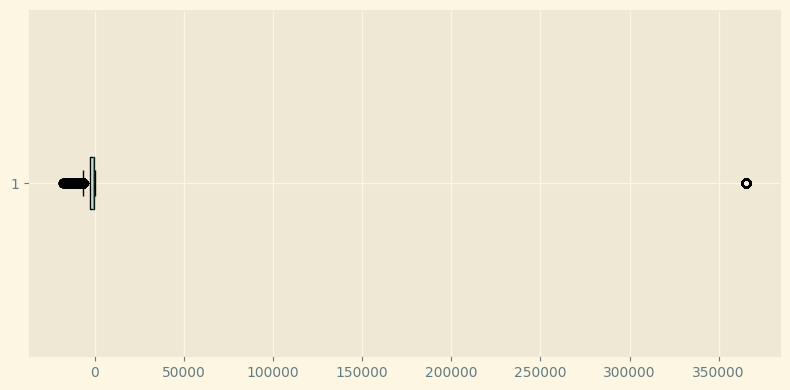

In [19]:
# What ?

fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(8, 4),
    dpi=pc_dpi,
)

days = df_train["DAYS_EMPLOYED"].values

ax1.boxplot(x=days, vert=False)

###
# Titles/Lables

#
###

fig.tight_layout()
plt.show()


In [20]:
df_train["DAYS_EMPLOYED"].value_counts()


 365243    55374
-200         156
-224         152
-230         151
-199         151
           ...  
-13961         1
-11827         1
-10176         1
-9459          1
-8694          1
Name: DAYS_EMPLOYED, Length: 12574, dtype: int64

Ok that explains the deletion by OP


In [21]:
df_train["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)


In [22]:
df_train["DAYS_EMPLOYED"]


0         -637.0
1        -1188.0
2         -225.0
3        -3039.0
4        -3038.0
           ...  
307506    -236.0
307507       NaN
307508   -7921.0
307509   -4786.0
307510   -1262.0
Name: DAYS_EMPLOYED, Length: 307511, dtype: float64

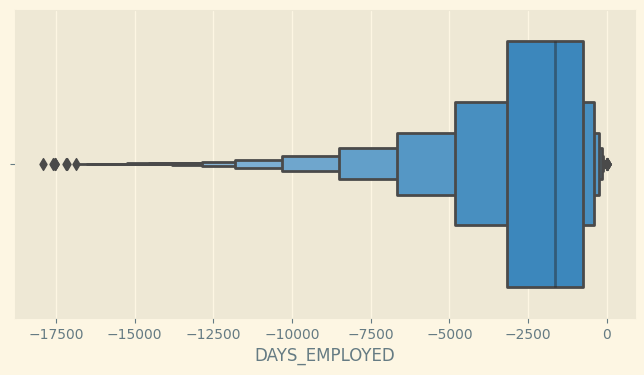

In [23]:
# What ?

fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(8, 4),
    dpi=pc_dpi,
)

days = df_train["DAYS_EMPLOYED"].values

g = sns.boxenplot(data=df_train, x="DAYS_EMPLOYED", ax=ax1)

###
# Titles/Lables

#
###

# fig.tight_layout()
plt.show()


47 years of employment is quite impressive but believable. Adding that to the preprocessing :

`dataframe["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)`

In [24]:
df_train = df_train.copy()  # defrag


In [25]:
variable_creation(dataframe=df_train)


In [26]:
df_train["REGION_RATING_CLIENT"]

0         2
1         1
2         2
3         2
4         2
         ..
307506    1
307507    2
307508    3
307509    2
307510    1
Name: REGION_RATING_CLIENT, Length: 307511, dtype: int64

# Adequate for now, moving on to bureau and bureau balance :

In [27]:
bureau_csv = "../data/bureau.csv"
bureau_balance = "../data/bureau_balance.csv"

df_bureau = pd.read_csv(filepath_or_buffer=bureau_csv)
df_bureau_balance = pd.read_csv(filepath_or_buffer=bureau_balance)


## Bureau :

In [28]:
df_bureau.columns


Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')

In [29]:
def preprocess_bureau(bureau_path: str):
    df_bureau = pd.read_csv(filepath_or_buffer=bureau_path)

    # Finding and encoding categorical columns :
    bureau_object = df_bureau.select_dtypes(include="object").columns
    one_hot_encode(
        dataframe=df_bureau,
        to_encode=bureau_object.tolist(),
        prefix=None,
        keep_na=True,
        drop_original=True
    )

    # Columns of bureau.csv to aggreagate with associated functions :
    bureau_aggregations = {
        "DAYS_CREDIT": ["min", "max", "mean"],
        "DAYS_CREDIT_ENDDATE": ["min", "max", "mean"],
        "CREDIT_DAY_OVERDUE": ["max", "mean"],
        "DAYS_CREDIT_UPDATE": ["mean"],
        "CNT_CREDIT_PROLONG": ["sum"],
        "AMT_ANNUITY": ["max", "mean", "sum"],
        "AMT_CREDIT_MAX_OVERDUE": ["sum"],
        "AMT_CREDIT_SUM": ["mean", "sum"],
        "AMT_CREDIT_SUM_DEBT": ["max", "mean", "sum"],
        "AMT_CREDIT_SUM_OVERDUE": ["mean", "max", "sum"],
        "AMT_CREDIT_SUM_LIMIT": ["mean", "sum"],
    }

    # Adding categorical aggregations (mean value) :
    # any col that startwith object_col has been encoded and removed
    encoded_cols = [col for col in df_bureau.columns if any(col.startswith(obj_col) for obj_col in bureau_object)]

    for col in encoded_cols:
        bureau_aggregations[col] = ["mean"]

    df_bureau_agg = df_bureau.groupby("SK_ID_CURR").agg(bureau_aggregations)
    df_bureau_agg.columns = pd.Index([f"{col[0]}_{col[1]}" for col in df_bureau_agg.columns.tolist()])

    return df_bureau_agg


In [30]:
df_bureau_prepro = preprocess_bureau(bureau_path="../data/bureau.csv")


In [31]:
df_bureau_prepro.head()


,DAYS_CREDIT_min,DAYS_CREDIT_max,DAYS_CREDIT_mean,DAYS_CREDIT_ENDDATE_min,DAYS_CREDIT_ENDDATE_max,DAYS_CREDIT_ENDDATE_mean,CREDIT_DAY_OVERDUE_max,CREDIT_DAY_OVERDUE_mean,DAYS_CREDIT_UPDATE_mean,CNT_CREDIT_PROLONG_sum,...,CREDIT_TYPE_Loan for business development_mean,CREDIT_TYPE_Loan for purchase of shares (margin lending)_mean,CREDIT_TYPE_Loan for the purchase of equipment_mean,CREDIT_TYPE_Loan for working capital replenishment_mean,CREDIT_TYPE_Microloan_mean,CREDIT_TYPE_Mobile operator loan_mean,CREDIT_TYPE_Mortgage_mean,CREDIT_TYPE_Real estate loan_mean,CREDIT_TYPE_Unknown type of loan_mean,CREDIT_TYPE_nan_mean
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,-1329.0,1778.0,82.428571,0,0.0,-93.142857,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100002,-1437,-103,-874.000000,-1072.0,780.0,-349.000000,0,0.0,-499.875000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100003,-2586,-606,-1400.750000,-2434.0,1216.0,-544.500000,0,0.0,-816.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100004,-1326,-408,-867.000000,-595.0,-382.0,-488.500000,0,0.0,-532.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100005,-373,-62,-190.666667,-128.0,1324.0,439.333333,0,0.0,-54.333333,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
def preprocess_credit_card(credit_card_path: str):
    df_credit_card = pd.read_csv(filepath_or_buffer=credit_card_path)

    df_credit_card.drop(['SK_ID_PREV'], axis=1, inplace=True)

    # Finding and encoding categorical columns :
    credit_card_object = df_credit_card.select_dtypes(include="object").columns

    one_hot_encode(
        dataframe=df_credit_card,
        to_encode=credit_card_object.tolist(),
        prefix=None,
        keep_na=True,
        drop_original=True
    )

    # columns to aggregate, mostly using sum in case of multiple cards by cx
    credit_card_aggregations = {
        "AMT_BALANCE": ["mean", "sum"],
        "AMT_CREDIT_LIMIT_ACTUAL": ["mean", "sum"],
        "AMT_DRAWINGS_ATM_CURRENT": ["mean", "sum"],
        "AMT_DRAWINGS_CURRENT": ["mean", "sum"],
        "AMT_DRAWINGS_OTHER_CURRENT": ["sum"],
        "AMT_DRAWINGS_POS_CURRENT": ["sum"],
        "AMT_INST_MIN_REGULARITY": ["mean"],
        "AMT_PAYMENT_CURRENT": ["mean"],
        "AMT_PAYMENT_TOTAL_CURRENT": ["mean"],
        "AMT_RECEIVABLE_PRINCIPAL": ["sum"],
        "AMT_RECIVABLE": ["sum"],
        "AMT_TOTAL_RECEIVABLE": ["sum"],
        "CNT_DRAWINGS_ATM_CURRENT": ["sum"],
        "CNT_DRAWINGS_CURRENT": ["sum"],
        "CNT_DRAWINGS_OTHER_CURRENT": ["sum"],
        "CNT_DRAWINGS_POS_CURRENT": ["sum"],
        "CNT_INSTALMENT_MATURE_CUM": ["sum"],
        "SK_DPD": ["mean", "max"],
        "SK_DPD_DEF": ["mean", "max"]
    }

    # Adding categorical aggregations (mean value) :
    # only one encoded col : NAME_CONTRACT_STATUS
    encoded_cols = [col for col in df_credit_card.columns if col.startswith("NAME_CONTRACT_STATUS_")]
    print(encoded_cols)

    for col in encoded_cols:
        credit_card_aggregations[col] = ["mean"]

    df_credit_card_agg = df_credit_card.groupby("SK_ID_CURR").agg(credit_card_aggregations)
    df_credit_card_agg.columns = pd.Index([f"{col[0]}_{col[1]}" for col in df_credit_card_agg.columns.tolist()])

    return df_credit_card_agg


In [33]:
df_cc_prepro = preprocess_credit_card(credit_card_path="../data/credit_card_balance.csv")


['NAME_CONTRACT_STATUS_Active', 'NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_Completed', 'NAME_CONTRACT_STATUS_Demand', 'NAME_CONTRACT_STATUS_Refused', 'NAME_CONTRACT_STATUS_Sent proposal', 'NAME_CONTRACT_STATUS_Signed', 'NAME_CONTRACT_STATUS_nan']


In [34]:
def preprocess_pos(pos_path: str):
    df_pos = pd.read_csv(filepath_or_buffer=pos_path)

    # Finding and encoding categorical columns :
    pos_object = df_pos.select_dtypes(include="object").columns

    one_hot_encode(
        dataframe=df_pos,
        to_encode=pos_object.tolist(),
        prefix=None,
        keep_na=True,
        drop_original=True
    )

    # columns to aggregate, mostly using sum in case of multiple cards by cx
    pos_aggregations = {
        "MONTHS_BALANCE": ["max", "mean"],
        "SK_DPD": ["max", "mean"],
        "CNT_INSTALMENT_FUTURE": ["sum"],
        "SK_DPD_DEF": ["max", "mean"]
    }

    # Adding categorical aggregations (mean value) :
    encoded_cols = [col for col in df_pos.columns if any(col.startswith(obj_col) for obj_col in pos_object)]
    for col in encoded_cols:
        pos_aggregations[col] = ["mean"]

    df_pos_agg = df_pos.groupby("SK_ID_CURR").agg(pos_aggregations)
    df_pos_agg.columns = pd.Index([f"{col[0]}_{col[1]}" for col in df_pos_agg.columns.tolist()])
    # Count pos cash accounts
    df_pos_agg["number_accounts"] = df_pos.groupby("SK_ID_CURR").size()

    return df_pos_agg


In [35]:
df_pos_prepro = preprocess_pos(pos_path="../data/POS_CASH_balance.csv")


In [36]:
df_pos_prepro.head()

,MONTHS_BALANCE_max,MONTHS_BALANCE_mean,SK_DPD_max,SK_DPD_mean,CNT_INSTALMENT_FUTURE_sum,SK_DPD_DEF_max,SK_DPD_DEF_mean,NAME_CONTRACT_STATUS_Active_mean,NAME_CONTRACT_STATUS_Amortized debt_mean,NAME_CONTRACT_STATUS_Approved_mean,NAME_CONTRACT_STATUS_Canceled_mean,NAME_CONTRACT_STATUS_Completed_mean,NAME_CONTRACT_STATUS_Demand_mean,NAME_CONTRACT_STATUS_Returned to the store_mean,NAME_CONTRACT_STATUS_Signed_mean,NAME_CONTRACT_STATUS_XNA_mean,NAME_CONTRACT_STATUS_nan_mean,number_accounts
SK_ID_CURR,,,,,,,,,,,,,,,,,,
100001,-53,-72.555556,7,0.777778,13.0,7,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.000000,0.0,0.0,9
100002,-1,-10.000000,0,0.000000,285.0,0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,19
100003,-18,-43.785714,0,0.000000,162.0,0,0.000000,0.928571,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,0.0,28
100004,-24,-25.500000,0,0.000000,9.0,0,0.000000,0.750000,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,0.0,4
100005,-15,-20.000000,0,0.000000,72.0,0,0.000000,0.818182,0.0,0.0,0.0,0.090909,0.0,0.0,0.090909,0.0,0.0,11


In [37]:
def preprocess_previous_app(previous_app_path: str) -> pd.DataFrame:
    df_app = pd.read_csv(filepath_or_buffer=previous_app_path)

    # Finding and encoding categorical columns :
    app_object = df_app.select_dtypes(include="object").columns
    one_hot_encode(
        dataframe=df_app,
        to_encode=app_object.tolist(),
        prefix=None,
        keep_na=True,
        drop_original=True
    )

    # Days columns 365.243 values -> nan
    for col in df_app.columns:
        if col.startswith("DAYS_"):
            df_app[col].replace(365243, np.nan, inplace=True)

    # columns to aggregate, mostly using sum in case of multiple cards by cx
    app_aggregations = {
        "AMT_ANNUITY": ["min", "max", "mean"],
        "AMT_APPLICATION": ["min", "max", "mean"],
        "AMT_CREDIT": ["min", "max", "mean"],
        "AMT_DOWN_PAYMENT": ["min", "max", "mean"],
        "AMT_GOODS_PRICE": ["min", "max", "mean"],
        "HOUR_APPR_PROCESS_START": ["min", "max", "mean"],
        "RATE_DOWN_PAYMENT": ["min", "max", "mean"],
        "CNT_PAYMENT": ["mean", "sum"],
        "DAYS_DECISION": ["min", "max", "mean"],
        "DAYS_FIRST_DRAWING": ["mean"],
        "DAYS_FIRST_DUE": ["mean"],
        "DAYS_LAST_DUE_1ST_VERSION": ["mean"],
        "DAYS_LAST_DUE": ["mean"],
        "DAYS_TERMINATION": ["mean"]
    }

    # Adding categorical aggregations (mean value) :
    encoded_cols = [col for col in df_app.columns if any(col.startswith(obj_col) for obj_col in app_object)]

    for col in encoded_cols:
        app_aggregations[col] = ["mean"]

    with warnings.catch_warnings():  # Silence fragmentation warning
        warnings.simplefilter('ignore')

        df_app_agg = df_app.groupby("SK_ID_CURR").agg(app_aggregations)
        df_app_agg.columns = pd.Index([f"{col[0]}_{col[1]}" for col in df_app_agg.columns.tolist()])
        df_app_agg["number_applications"] = df_app.groupby("SK_ID_CURR").size()

    return df_app_agg


In [38]:
df_prev_app = preprocess_previous_app("../data/previous_application.csv")

In [39]:
def preprocess_installments(installments_path: str) -> pd.DataFrame:

    df_installments = pd.read_csv(filepath_or_buffer=installments_path)

    # Days past due and days before due (no negative values)
    df_installments["DPD"] = df_installments["DAYS_ENTRY_PAYMENT"] - df_installments["DAYS_INSTALMENT"]
    df_installments["DBD"] = df_installments["DAYS_INSTALMENT"] - df_installments["DAYS_ENTRY_PAYMENT"]
    df_installments["DPD"] = df_installments["DPD"].apply(lambda x: x if x > 0 else 0)
    df_installments["DBD"] = df_installments["DBD"].apply(lambda x: x if x > 0 else 0)

    # Features: Perform aggregations
    aggregations = {
        "NUM_INSTALMENT_VERSION": ["nunique"],
        "DPD": ["max", "mean", "sum"],
        "DBD": ["max", "mean", "sum"],
        "AMT_INSTALMENT": ["max", "mean", "sum"],
        "AMT_PAYMENT": ["min", "max", "mean", "sum"],
        "DAYS_ENTRY_PAYMENT": ["max", "mean", "sum"]
    }

    df_inst_agg = df_installments.groupby("SK_ID_CURR").agg(aggregations)
    df_inst_agg.columns = pd.Index([f"{col[0]}_{col[1]}" for col in df_inst_agg.columns.tolist()])

    # Count installments accounts
    df_inst_agg["number_accounts"] = df_installments.groupby("SK_ID_CURR").size()
    
    return df_inst_agg


In [41]:
df_inst = pd.read_csv("../data/installments_payments.csv")

df_inst.head()


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [42]:
df_inst.dtypes

SK_ID_PREV                  int64
SK_ID_CURR                  int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER       int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtype: object

In [ ]:
def installments_payments(num_rows=None, nan_as_category=True):
    """
    Preprocess installments_payments.csv
    """
    ins = pd.read_csv("../input/installments_payments.csv", nrows=num_rows)

    # Days past due and days before due (no negative values)
    ins["DPD"] = ins["DAYS_ENTRY_PAYMENT"] - ins["DAYS_INSTALMENT"]
    ins["DBD"] = ins["DAYS_INSTALMENT"] - ins["DAYS_ENTRY_PAYMENT"]
    ins["DPD"] = ins["DPD"].apply(lambda x: x if x > 0 else 0)
    ins["DBD"] = ins["DBD"].apply(lambda x: x if x > 0 else 0)

    # Features: Perform aggregations
    aggregations = {
        "NUM_INSTALMENT_VERSION": ["nunique"],
        "DPD": ["max", "mean", "sum"],
        "DBD": ["max", "mean", "sum"],
        "AMT_INSTALMENT": ["max", "mean", "sum"],
        "AMT_PAYMENT": ["min", "max", "mean", "sum"],
        "DAYS_ENTRY_PAYMENT": ["max", "mean", "sum"]
    }

    ins_agg = ins.groupby("SK_ID_CURR").agg(aggregations)
    ins_agg.columns = pd.Index(["INSTAL_" + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

    # Count installments accounts
    ins_agg["INSTAL_COUNT"] = ins.groupby("SK_ID_CURR").size()
    del ins
    gc.collect()
    return ins_agg
